In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

useducation_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [4]:
# First interpolate the data

fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G"]

states = useducation_df["STATE"].unique()

for state in states:
    useducation_df.loc[useducation_df["STATE"] == state, fill_list] = useducation_df.loc[useducation_df["STATE"] == state, fill_list].interpolate()

# Then drop the remaining null values
useducation_df.dropna(inplace=True)

In [5]:
useducation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 209 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     466 non-null object
STATE                           466 non-null object
YEAR                            466 non-null int64
ENROLL                          466 non-null float64
TOTAL_REVENUE                   466 non-null float64
FEDERAL_REVENUE                 466 non-null float64
STATE_REVENUE                   466 non-null float64
LOCAL_REVENUE                   466 non-null float64
TOTAL_EXPENDITURE               466 non-null float64
INSTRUCTION_EXPENDITURE         466 non-null float64
SUPPORT_SERVICES_EXPENDITURE    466 non-null float64
OTHER_EXPENDITURE               466 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      466 non-null float64
GRADES_PK_G                     466 non-null float64
GRADES_KG_G                     466 non-null float64
GRADES_4_G                      466 non-null float64
GRADES_8_G                      466 non-null flo

#### 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

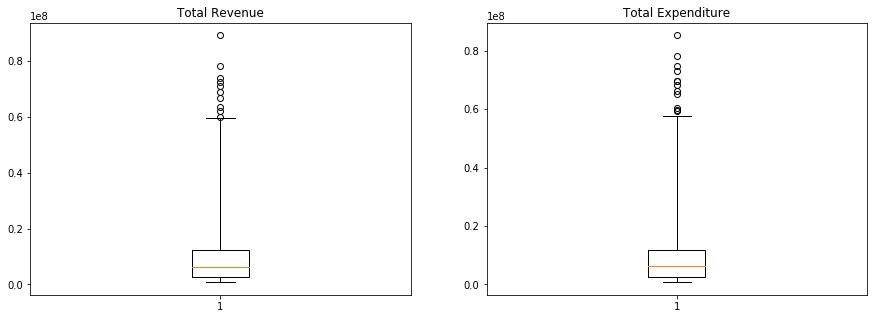

In [8]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(useducation_df["TOTAL_REVENUE"], whis = 5)
plt.title("Total Revenue")

plt.subplot(1,2,2)
plt.boxplot(useducation_df["TOTAL_EXPENDITURE"], whis = 5)
plt.title("Total Expenditure")
plt.show()

## Both variables have outlier values

#### 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

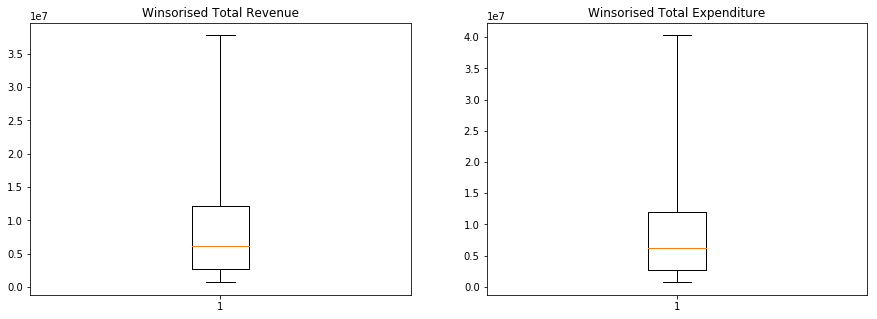

In [15]:
from scipy.stats.mstats import winsorize

winsorized_revenue = winsorize(useducation_df["TOTAL_REVENUE"], (0, 0.05))

winsorized_expenditure = winsorize(useducation_df["TOTAL_EXPENDITURE"], (0, 0.05))

## Check to see if this technique eliminated the outliers

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(winsorized_revenue, whis = 5)
plt.title("Winsorised Total Revenue")

plt.subplot(1,2,2)
plt.boxplot(winsorized_expenditure, whis = 5)
plt.title("Winsorised Total Expenditure")
plt.show()


#### 3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

Text(0.5, 1.0, 'Budget Deficit')

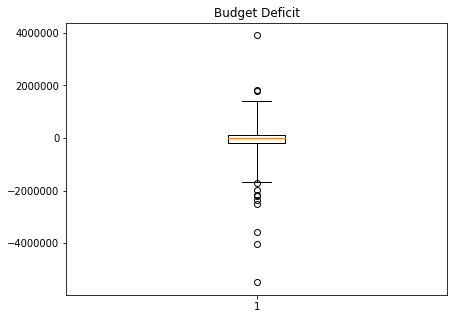

In [17]:
budget_deficit = useducation_df["TOTAL_REVENUE"] - useducation_df["TOTAL_EXPENDITURE"]

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.boxplot(budget_deficit, whis = 5)
plt.title("Budget Deficit")

Text(0.5, 1.0, 'Winsorized Budget Deficit')

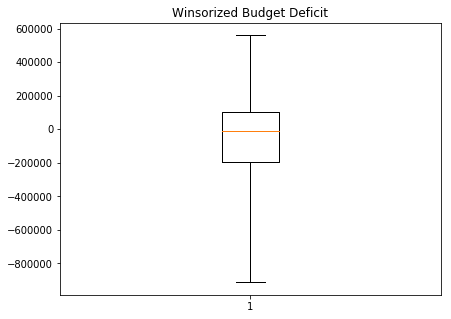

In [24]:
winsorized_deficit = winsorize(budget_deficit, (0.05, 0.05))

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.boxplot(winsorized_deficit, whis = 5)
plt.title("Winsorized Budget Deficit")

#### 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

Text(0.5, 1.0, 'Pre-Winsorized Budget Deficit')

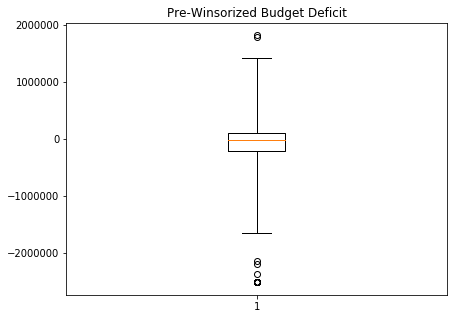

In [26]:
winsorized_deficit_before = winsorized_revenue - winsorized_expenditure

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.boxplot(winsorized_deficit_before, whis = 5)
plt.title("Pre-Winsorized Budget Deficit")

Text(0.5, 1.0, 'Re-Winsorized Budget Deficit')

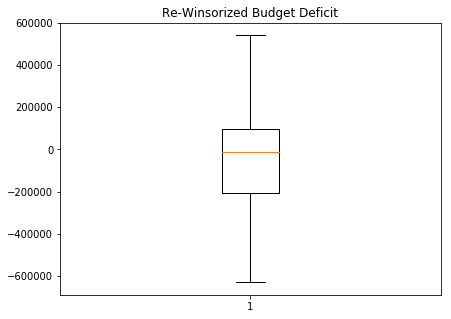

In [29]:
rewinsorized_deficit = winsorize(winsorized_deficit_before, (0.1, 0.05))

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.boxplot(rewinsorized_deficit, whis = 5)
plt.title("Re-Winsorized Budget Deficit")

#### 5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

In [37]:
print(winsorized_deficit.mean(), rewinsorized_deficit.mean())

print(winsorized_deficit.std(), rewinsorized_deficit.std())

-58733.01287553648 -51370.62875536481
340934.4172407685 299790.12178862427


#### 6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

The method in the third question would be best because you only have to winsorize at the end, instead of winsorizing both variables and the difference between the variables.